# 0.0 Import

In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import gridspec

from scipy import stats

## 0.1 Load data

In [3]:
df_raw_a = {'visits_A': [24186, 22240, 21915, 24046, 21620, 21651, 22624, 25476, 24232,
                         26996, 24418, 26906, 21262, 20247, 21377, 21237, 26087, 25624,
                         24754, 23289, 21968, 21819, 20614, 18778, 23902, 21089, 19599,
                         16136, 19584, 16925, 23675, 26319, 20691, 21535, 25220, 22885,
                         24725, 25090, 26551, 24389, 23229, 24359, 25755, 25270, 23617,
                         21501, 24459, 23413, 21180, 19490, 28164, 19612, 21427, 27168,
                         25076, 25819, 26386, 26784, 23879, 24669, 22962, 24776, 23591,
                         20815, 22421, 25605, 24855, 20280, 22752, 716],
            'clicks_A': [1642, 1660, 1728, 1878, 1234, 1320, 1826, 2768, 2940, 3016, 2060,
                         3072, 1984, 1544, 1496, 1372, 2278, 1314, 2284, 1452, 1810, 2162,
                         1410, 1294, 2096, 1366, 1262, 1022, 1444, 1114, 1688, 2362, 1210,
                         1518, 3646, 1954, 2146, 2100, 2794, 2064, 1886, 1732, 2878, 1700,
                         1968, 1430, 1254, 1642, 1558, 1148, 1282, 1264, 1568, 2254, 1416,
                         1778, 2072, 2248, 1682, 1152, 1540, 1270, 1848, 1928, 1464, 1746,
                         2222, 1184, 1170, 62]}

df_raw_b = {'visits_B': [24909, 22986, 22953, 24896, 22284, 22563, 23196, 26238, 24871,
                         27869, 25301, 27779, 22008, 21020, 22037, 22006, 27070, 26169,
                         25518, 24043, 22593, 22195, 21015, 19337, 24448, 21765, 19933,
                         16672, 20329, 17638, 24427, 27232, 21468, 21966, 25987, 23607,
                         25487, 25926, 27237, 25163, 23965, 25037, 26214, 25999, 24272,
                         22336, 25271, 24220, 22014, 20195, 29069, 20320, 22058, 28055,
                         25992, 26678, 26949, 27701, 24951, 25561, 23766, 25646, 24677,
                         21441, 23269, 26265, 25563, 20869, 23276, 707],
            'clicks_B': [1714, 1778, 1848, 2008, 1270, 1372, 1868, 2872, 3014, 3110, 2094,
                         3278, 1982, 1648, 1500, 1362, 2582, 2326, 2386, 1540, 1892, 2160,
                         1476, 1336, 2108, 1418, 1252, 1078, 1550, 1156, 1860, 2288, 1228,
                         1602, 3766, 2000, 2320, 2166, 3010, 2010, 1928, 1890, 2960, 1716,
                         1950, 1534, 1418, 1796, 1522, 1224, 1346, 1350, 1534, 2436, 1404,
                         1790, 2180, 2574, 1824, 1162, 1586, 1390, 1950, 2020, 1484, 1818,
                         2348, 1280, 1136, 60]}

In [8]:
df = pd.concat([pd.DataFrame(df_raw_a), pd.DataFrame(df_raw_b)], axis=1)

# 1.0 Teste Frequentista

In [10]:
df['acc_visits_A'] = np.cumsum(df['visits_A'])
df['acc_clicks_A'] = np.cumsum(df['clicks_A'])

df['acc_visits_B'] = np.cumsum(df['visits_B'])
df['acc_clicks_B'] = np.cumsum(df['clicks_B'])

df['conversion'] = (df['clicks_A'] + df['clicks_B']) / (df['visits_A'] + df['visits_A'])

In [12]:
# Fazendo Z-test
numerador = (df['acc_clicks_B'] / df['acc_visits_B']) - (df['acc_clicks_A'] / df['acc_visits_A'])
denominador = np.sqrt((df['conversion'] * (1-df['conversion'])) * ((1/df['acc_visits_A']) + (1/df['acc_visits_B'])))

df['z'] = numerador / denominador

In [14]:
df['ctr_A'] = df['acc_clicks_A'] / df['acc_visits_A']
df['ctr_B'] = df['acc_clicks_B'] / df['acc_visits_B']

df['acc_ctr_A'] = df['ctr_A'].cumsum()
df['acc_ctr_B'] = df['ctr_B'].cumsum()

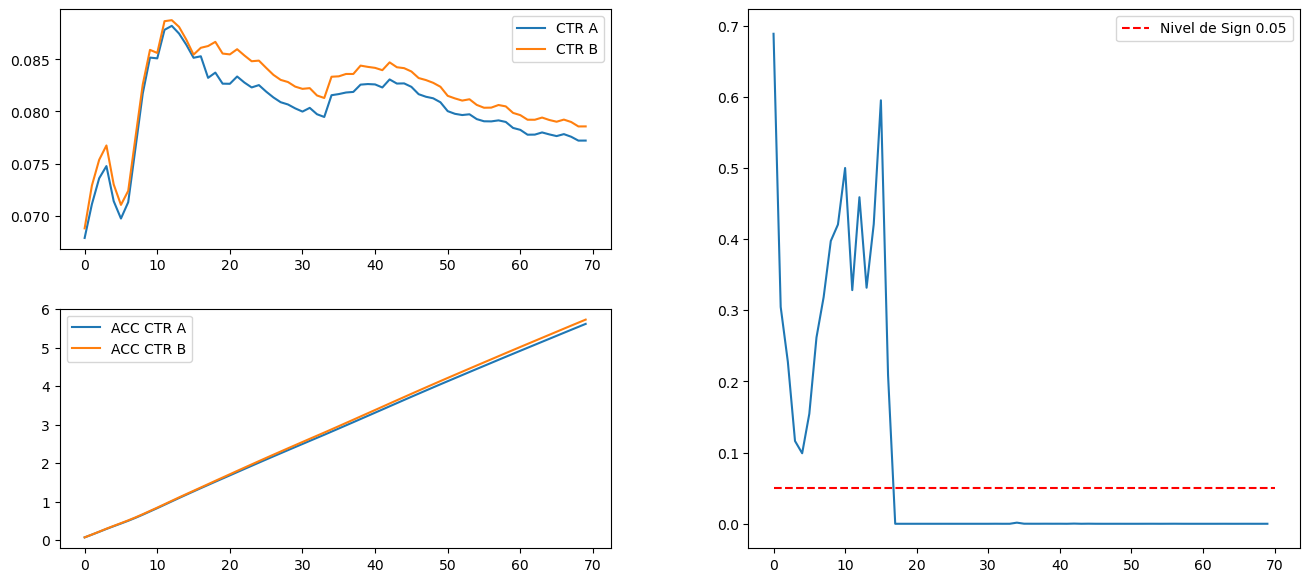

In [22]:
f = plt.figure(figsize=(16, 7))
gs0 = gridspec.GridSpec(2, 2, figure=f, wspace=0.25, hspace=0.25)

ax1 = f.add_subplot(gs0[:1, :1])
ax2 = f.add_subplot(gs0[1:, :1])
ax3 = f.add_subplot(gs0[:, 1:])

ax1.plot(df['ctr_A'], label='CTR A')
ax1.plot(df['ctr_B'], label='CTR B')
ax1.legend()

ax2.plot(df['acc_ctr_A'], label='ACC CTR A')
ax2.plot(df['acc_ctr_B'], label='ACC CTR B')
ax2.legend()

ax3.plot(df['z'].index, (2* (1- stats.norm.cdf(df['z']))))
ax3.hlines(0.05, 0, 70, color='red', linestyles='--', label='Nivel de Sign 0.05')
ax3.legend();

# 2.0 Teste Bayesiano

In [27]:
df1 = df.copy()

In [42]:
N_mc = 100000
proba_b_better_a = []
excpected_loss_a = []
excpected_loss_b = []

for day in range(len(df1)):
    u_a, var_a = stats.beta.stats(a = 1 + df1.loc[day, 'acc_clicks_A'],
                                  b = 1 + (df1.loc[day, 'acc_visits_A'] - df1.loc[day, 'acc_clicks_A']),
                                  moments='mv')
    
    u_b, var_b = stats.beta.stats(a = 1 + df1.loc[day, 'acc_clicks_B'],
                                  b = 1 + (df1.loc[day, 'acc_visits_B'] - df1.loc[day, 'acc_clicks_B']),
                                  moments='mv')

    # Amostras da distribuição Normal A
    x_a = np.random.normal(loc=u_a,
                            scale= 1.25*np.sqrt(var_a),
                            size=N_mc)

    # Amostras da distribuição Normal B
    x_b = np.random.normal(loc=u_b,
                            scale= 1.25*np.sqrt(var_b),
                            size=N_mc)

    # Beta distribuition function of page A
    fa = stats.beta.pdf(x_a,
                        a = 1 + df1.loc[day, 'acc_clicks_A'],
                        b = 1 + (df1.loc[day, 'acc_visits_A'] - df1.loc[day, 'acc_clicks_A'])
                            )

    # Beta distribuition function of page B
    fb = stats.beta.pdf(x_b,
                        a = 1 + df1.loc[day, 'acc_clicks_B'],
                        b = 1 + (df1.loc[day, 'acc_visits_B'] - df1.loc[day, 'acc_clicks_B'])
                            )


    # Normal distribuition function of page A
    ga = stats.norm.pdf(x_a,
                        loc=u_a,
                        scale=1.25*np.sqrt(var_a))

    # Normal distribuition function of page B
    gb = stats.norm.pdf(x_b,
                        loc=u_b,
                        scale=1.25*np.sqrt(var_b))

    # Beta / Normal
    y = (fa*fb) / (ga*gb)

    # Somente valores onde o B é maior do que A
    yb = y[x_b >= x_a]

    # Probabilidade de B ser melhor do que A
    p = (1 / N_mc) * np.sum(yb)

    # Erro ao assumir B melhor do que A
    excpected_loss_A = (1/N_mc) * np.sum(((x_b - x_a)*y)[x_b >= x_a])
    excpected_loss_B = (1/N_mc) * np.sum(((x_a - x_b)*y)[x_a >= x_b])

    proba_b_better_a.append(p)
    excpected_loss_a.append(excpected_loss_A)
    excpected_loss_b.append(excpected_loss_B)

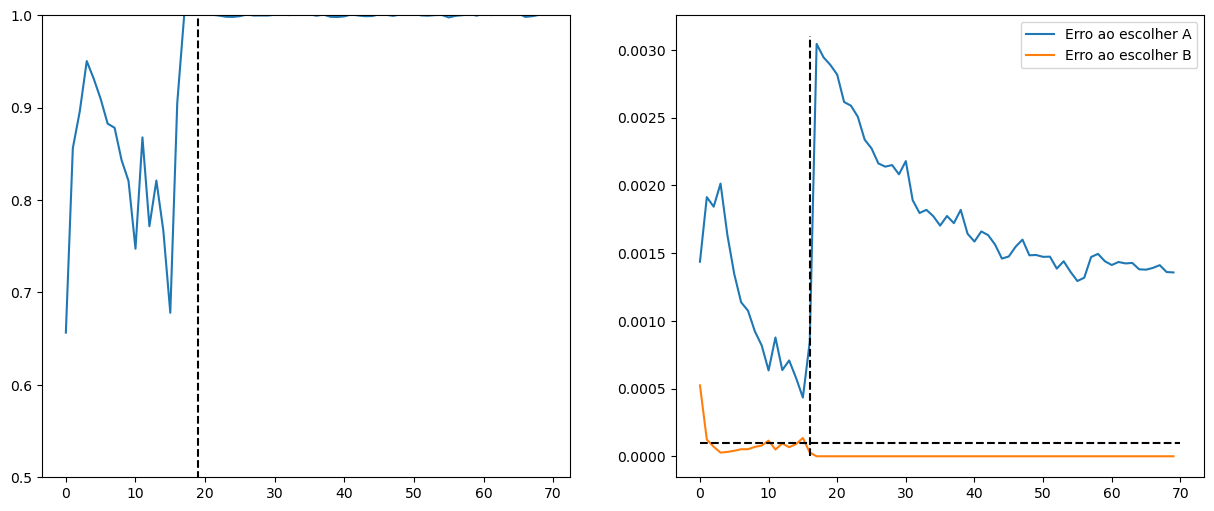

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].set_ylim(0.5, 1)
axs[0].plot(proba_b_better_a)
axs[0].vlines(19, 0, 1.0, color='black', linestyles='--')

axs[1].plot(excpected_loss_a, label="Erro ao escolher A")
axs[1].plot(excpected_loss_b, label="Erro ao escolher B")
axs[1].hlines(0.0001, 0, 70, color='black', linestyle='--')
axs[1].vlines(16, 0, 0.0031, color='black', linestyle='--')
plt.legend();

In [1]:
import pandas as pd

In [8]:
click = 1
visit = 1
group = "control"

df_raw = pd.DataFrame({"click": [click], "visit": [visit], "group": [group]})

df_raw.to_csv('../data/01_raw/data_experiment.csv')